# ConvNet from Scratch

## Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Padding

In [2]:
def pad_image(X, pad, value = 0):
    """
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) 
         representing a batch of m images
    
    pad -- integer, amount of padding around each image on vertical 
           and horizontal dimensions
    
    value -- what value to pad the image with
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2 * pad, n_W + 2 * pad, n_C)
    """
    
    value = np.float32(value)
    X_pad = np.pad(X, 
                   ((0,0), (pad, pad), (pad, pad), (0,0)), 
                   mode = 'constant',
                   constant_values = (value, value))
    
    return X_pad

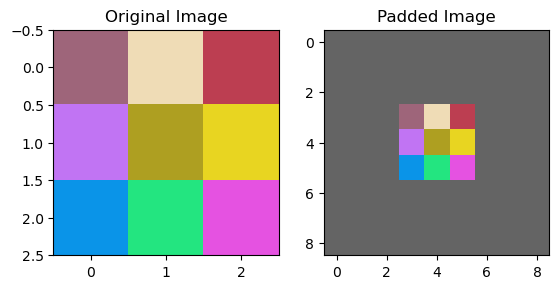

In [3]:
np.random.seed(1)
x = np.random.randn(5, 3, 3, 3) ; x *= 255
x_pad = pad_image(x, 3, 100)
x = np.uint8(x) ; x_pad = np.uint8(x_pad)

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(x[0])

plt.subplot(1, 2, 2)
plt.title('Padded Image')
plt.imshow(x_pad[0])

## Single Step Convolution

In [4]:
def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice 
    (a_slice_prev) of the output activation of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window 
        matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window  
         matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
    """
    
    temp = np.multiply(a_slice_prev, W)
    temp = np.sum(temp)
    Z = np.float64(temp + b)

    return Z

## CNN Forward Propagation

### Determine the image size after convolution

$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_C = \text{number of filters used in the convolution}$$
 

In [5]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Arguments:
    A_prev -- output activations of the previous layer, 
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    # extract size information
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # get image size after convolution
    n_H = int((n_H_prev + 2 * pad - f) / stride) + 1
    n_W = int((n_W_prev + 2 * pad - f) / stride) + 1
    
    # store image after convolution
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # pad image with zeros
    A_prev_pad = pad_image(A_prev, pad, value = 0)
    
    # iterate over training examples
    for i in range(m):
        
        #select one training example
        a_prev_pad = A_prev_pad[i]
        
        # iterate over image height (matrix row)
        for h in range(n_H):
            
            # find image vertical start and end
            vert_start = h * stride
            vert_end = vert_start + f
            
            # iterate over image width (matrix column)
            for w in range(n_W):
                
                # find image horizontal start and end 
                horiz_start = w * stride
                horiz_end = horiz_start + f
                
                # interate over image channels (matrix channel)
                for c in range(n_C):
                    a_slice_prev = a_prev_pad[vert_start:vert_end, 
                                             horiz_start:horiz_end,
                                             :]
                    weights = W[:, :, :, c]
                    biases = b[:, :, :, c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, 
                                                     weights, 
                                                     biases)
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

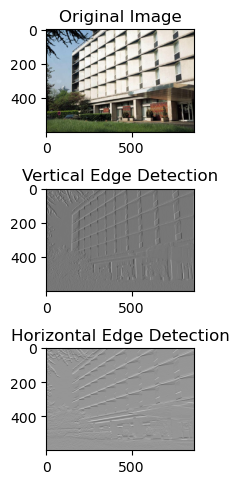

In [18]:
# read and contruct image matrix
img = plt.imread('example.jpg')
n_H, n_W, n_C = img.shape
temp = np.zeros((1, n_H, n_W, n_C))
temp[0, :, :, :] = img
batch_img = temp
batch_img = np.uint8(batch_img)

# contruct filter parameters
W = np.zeros((3, 3, 3, 2))
vertical_detection = np.array([[1,0,-1],
                               [1,0,-1],
                               [1,0,-1]])

horizontal_detection = np.array([[1,1,1],
                               [0,0,0],
                               [-1,-1,-1]])

W[:,:,0,0] = vertical_detection 
W[:,:,1,0] = vertical_detection 
W[:,:,2,0] = vertical_detection
W[:,:,0,1] = horizontal_detection 
W[:,:,1,1] = horizontal_detection 
W[:,:,2,1] = horizontal_detection

# bias
b = np.zeros((1, 1, 1, 2))

#hparameters
hpar = {"pad": 1, "stride": 1}

# convolution
Z, catch_conv = conv_forward(batch_img, W, b, hpar)

fig, ax = plt.subplots(3, 1)
fig.tight_layout(h_pad = 2)

#plt.subplot(3,1,1)
ax[0].set_title('Original Image')
ax[0].imshow(img)

#plt.subplot(3,1,2)
ax[1].set_title('Vertical Edge Detection')
ax[1].imshow(Z[0,:,:,0], 'gray')

#plt.subplot(3,1,3)
ax[2].set_title('Horizontal Edge Detection')
ax[2].imshow(Z[0,:,:,1], 'gray')


## Forward Pooling
$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f}{stride} \Bigr\rfloor +1$$

$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f}{stride} \Bigr\rfloor +1$$

$$n_C = n_{C_{prev}}$$

In [7]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, 
    numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    
    hparameters -- python dictionary containing "f" and "stride"
    
    mode -- max pooling or average pooling
    
    Returns:
    A -- output of the pool layer, 
    a numpy array of shape (m, n_H, n_W, n_C)
    
    cache -- cache used in the backward pass of the pooling layer, 
    contains the input and hparameters 
    """
    
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    for i in range(m):                   
        a_prev = A_prev[i]
        
        for h in range(n_H): 
            vert_start = h * stride
            vert_end = vert_start + f
            
            for w in range(n_W):
                horiz_start = w * stride
                horiz_end = horiz_start + f
                
                for c in range (n_C):           
                    
                    a_prev_slice = a_prev[vert_start:vert_end,
                                         horiz_start:horiz_end,
                                         c]

                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    cache = (A_prev, hparameters)
    
    return A, cache

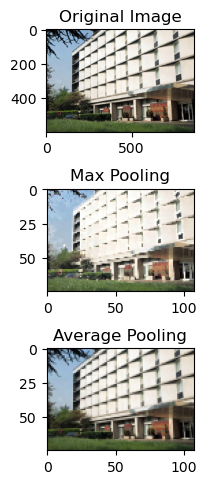

In [22]:
hpar = {"f": 8, "stride": 8}
A_max, cache_max_pooling = pool_forward(batch_img, hpar, mode = 'max')
A_avg, cache_avg_pooling = pool_forward(batch_img, hpar, mode = 'average')
A_max = np.uint8(A_max) ; A_avg = np.uint8(A_avg)


fig, ax = plt.subplots(3, 1)
fig.tight_layout(h_pad = 2)

#plt.subplot(3,1,1)
ax[0].set_title('Original Image')
ax[0].imshow(img)

#plt.subplot(3,1,2)
ax[1].set_title('Max Pooling')
ax[1].imshow(A_max[0])

#plt.subplot(3,1,3)
ax[2].set_title('Average Pooling')
ax[2].imshow(A_avg[0])

## CNN Backpropagation 

### Convolutional Layer Backward Pass 

#### Computing dA:
This is the formula for computing $dA$ with respect to the cost for a certain filter $W_c$ and a given training example:

$$A * W = Z$$

$$\frac{\partial J}{\partial A} = \frac{\partial J}{\partial Z} \times \frac{\partial Z}{\partial A} = dZ * \frac{\partial Z}{\partial A}$$

$$\frac{\partial Z}{\partial A} = dA \mathrel{+}= \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw} \tag{1}$$

* $W_c$ is a filter
* $dZ_{hw}$ is a scalar corresponding to the gradient of the cost with respect to the output of the conv layer Z at the hth row and wth column (corresponding to the dot product taken at the ith stride left and jth stride down)

#### Computing dW:
* $dW_c$ is the derivative of one filter with respect to the loss:
* $a_{slice}$ corresponds to the slice which was used to generate the activation $Z_{ij}$. 

$$dW_c  \mathrel{+}= \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} a_{slice} \times dZ_{hw}  \tag{2}$$

#### Computing db:

$$db = \sum_h \sum_w dZ_{hw} \tag{3}$$

* $db$ is the derivation of bias with respect to the cost for a certain filter $W_c$
 

In [23]:
def conv_backward(dZ, cache):
    """
    Implement the backward propagation for a convolution function
    
    Arguments:
    dZ -- gradient of the cost with respect to the output of 
    the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
    
    cache -- cache of values needed for the conv_backward(), output of conv_forward()
    
    Returns:
    dA_prev -- gradient of the cost with respect to the input of 
               the conv layer (A_prev), 
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    
    dW -- gradient of the cost with respect to the weights of 
          the conv layer (W), numpy array of shape (f, f, n_C_prev, n_C)
    
    db -- gradient of the cost with respect to the biases of 
          the conv layer (b), numpy array of shape (1, 1, 1, n_C)
    """    
    
    # Retrieve information from "cache"
    (A_prev, W, b, hparameters) = cache
    
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters"
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Retrieve dimensions from dZ's shape
    (m, n_H, n_W, n_C) = dZ.shape
    
    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))                          
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))
    
    # Pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m): 
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        
        for h in range(n_H):                   
            for w in range(n_W):               
                for c in range(n_C):       
                    
                    # Find the corners of the current "slice"
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f

                    # Use the corners to define the slice from a_prev_pad
                    a_slice = a_prev_pad[vert_start:vert_end,
                                        horiz_start:horiz_end]
                    
                    
                    
                    da_prev_pad[vert_start:vert_end, 
                                horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    
    return dA_prev, dW, db

## Max Pooling backward

In [24]:
def create_mask_from_window(x):
    """
    Creates a mask from an input matrix x, to identify the max entry of x.
    
    Arguments:
    x -- Array of shape (f, f)
    
    Returns:
    mask -- Array of the same shape as window, contains a True at the position corresponding to the max entry of x.
    """   
    mask = (x == np.max(x))
    return mask

## Average Pooling Backward

In [25]:
def distribute_value(dz, shape):
    """
    Distributes the input value in the matrix of dimension shape
    
    Arguments:
    dz -- input scalar
    shape -- the shape (n_H, n_W) of the output matrix for 
    which we want to distribute the value of dz
    
    Returns:
    a -- Array of size (n_H, n_W) for which we distributed the value of dz
    """    
    
    (n_H, n_W) = shape
    average = dz / (n_H * n_W)
    a = np.ones((n_H, n_W)) * average
    return a

## Put two pooling methods together

In [26]:
def pool_backward(dA, cache, mode = "max"):
    """
    Implements the backward pass of the pooling layer
    
    Arguments:
    dA -- gradient of cost with respect to the output of the 
          pooling layer, same shape as A_prev
    
    cache -- cache output from the forward pass of the pooling layer, 
             contains the layer's input and hparameters 
    
    mode -- "max" or "average"
    
    Returns:
    dA_prev -- gradient of cost with respect to the input of the 
    pooling layer, same shape as A_prev
    """
    
    (A_prev, hparameters) = cache
    stride = hparameters['stride']
    f = hparameters['f']
    
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):
        
        a_prev = A_prev[i]
        
        for h in range(n_H):                   
            for w in range(n_W):               
                for c in range(n_C):           
        
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    if mode == "max":
                        a_prev_slice = a_prev[vert_start:vert_end, 
                                             horiz_start:horiz_end,
                                             c]
                        mask = create_mask_from_window(a_prev_slice)

                        
                        dA_prev[i, vert_start: vert_end, horiz_start: 
                                horiz_end, c] += mask * dA[i, h, w, c]
                    elif mode == "average":
                        da = dA[i, h, w, c]
                        shape = (f, f)
                        dA_prev[i, vert_start: vert_end, horiz_start: 
                                horiz_end, c] += distribute_value(da, shape)
    return dA_prev